In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# New Networks transfer-learning on Cifar-10

In [75]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

batch_size = 2056

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [60]:
weights = models.AlexNet_Weights.DEFAULT
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
print("Training Data Shape:", trainset.data.shape, "\n However because of the transformation, the image are going to be resized to 224x224 cuz that's what AlexNet asks for.") 

Training Data Shape: (50000, 32, 32, 3)


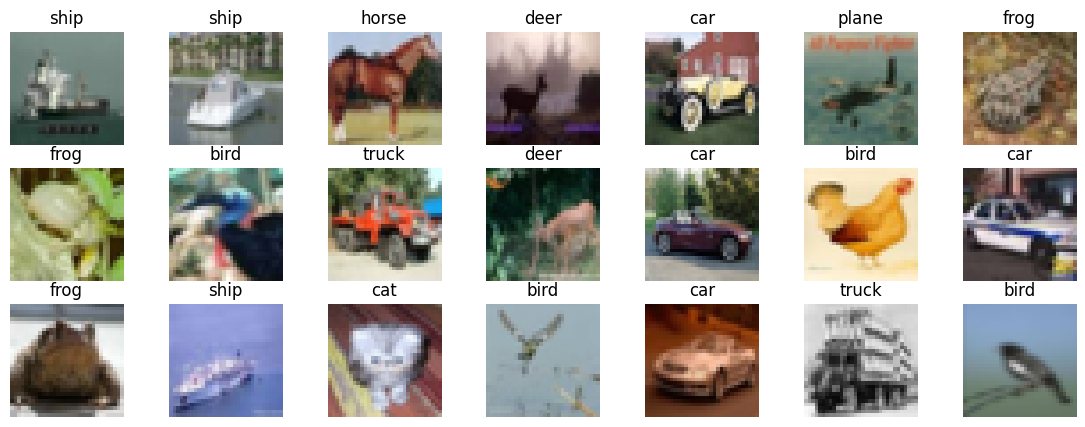

In [62]:
fig, axis = plt.subplots(nrows=3, ncols=7, figsize=(14, 5))

for ax, _ in zip(axis.ravel(), range(21)):
    inx = np.random.randint(len(trainset))
    ax.imshow(trainset.data[inx])
    ax.set_title(classes[trainset.targets[inx]], fontsize=12)
    ax.axis(False);

In [63]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {}
dataloaders['train'] = trainloader
dataloaders['test'] = testloader

# AlexNet Model

In [64]:
AlexneT = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

In [65]:
model = AlexneT.to(device)
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 1000]                --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          23,296
│    └─ReLU: 2-2                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]        

In [66]:
model.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

# AlexNet tuned for Cifar-10

In [67]:
modified_AlexNet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
for param in modified_AlexNet.parameters():
    param.requires_grad = False

In [68]:
modified_AlexNet.avgpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

modified_AlexNet.classifier = nn.Sequential()
modified_AlexNet.classifier.add_module('dropout1', nn.Dropout(p=0.5))
modified_AlexNet.classifier.add_module('linear1', nn.Linear(in_features=1024, out_features=512))
modified_AlexNet.classifier.add_module('relu1', nn.ReLU(inplace=True))
modified_AlexNet.classifier.add_module('dropout2', nn.Dropout(p=0.5))
modified_AlexNet.classifier.add_module('linear2', nn.Linear(in_features=512, out_features=512))
modified_AlexNet.classifier.add_module('relu2', nn.ReLU(inplace=True))
modified_AlexNet.classifier.add_module('dropout3', nn.Dropout(p=0.5))
modified_AlexNet.classifier.add_module('linear3', nn.Linear(in_features=512, out_features=10))
# avgpool changed idk why
# new avgpool has output size 1024, then fcn's are changed to match w/ it
# added dropout layers between fcn to prevent overfitting

In [69]:
summary(modified_AlexNet, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          (23,296)
│    └─ReLU: 2-2                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         (307,392)
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         (663,936)
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         (884,992)
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]

In [70]:
model_to_train = modified_AlexNet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_to_train.parameters(), lr=0.001)

## Train / Test functions

In [71]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [72]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

In [73]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

In [74]:
n_epochs = 1

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in trainloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in testloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs} | Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/5 | Training loss: 1.0327 | Training accuracy: 0.7280 | Test loss: 0.6749 | Test accuracy: 0.7781
Epoch: 2/5 | Training loss: 0.8466 | Training accuracy: 0.7963 | Test loss: 0.6288 | Test accuracy: 0.7861


KeyboardInterrupt: 